# Analysis of primary human hepatocytes LRTS

This notebook replicates the analysis from the paper 

IsoTools: IsoTools: a python toolbox for long-read transcriptome sequencing (in preparation)

As it involves integration of short read data, the analysis is quite complex. For demonstration of the functionality of the isotools framework with respect to processing of LRTS data, the [documentation provides more basic tutorials](https://isotools.readthedocs.io/en/latest/tutorials.html). 

## Preparation
### Preparation of the working directory and download of reference and data files
``` bash
    cd /my/working/directory
    # create some subdirectories
    mkdir -p reference ccs refine flnc aligned rnaseq/fastq rnaseq/star/reference pickle cage tables plots
    
    # download the reference genome (806 MB)
    genome_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/GRCh38.p13.genome.fa.gz'
    wget -P reference/ -O GRCh38.p13.genome.fa.gz ${genome_link} 
    gunzip reference/GRCh38.p13.genome.fa.gz
    
    # download gencode reference annotation (46.2 MB)
    gff='gencode.v36.chr_patch_hapl_scaff.annotation'
    annotation_link= ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/${gff}.gff3.gz
    wget -P reference/ ${annotation_link} 
    
    # sort by chromosome and position
    (zcat ${gff}.gff3.gz| grep ^"#" ; zcat reference/${gff}.gff3.gz|grep -v ^"#"| sort -k1,1 -k4,4n)|bgzip  > reference/${gff}_sorted.gff3.gz
    # create index
    tabix -p gff reference/${gff}_sorted.gff3.gz
    
    # download the isoseq circular consensus read (ccs) files (15.3 GB)
    isoseq_link='wget ftp://ftp.sra.ebi.ac.uk/vol1/[accession: PRJEB46194 -  add link here when sra published the data]'
    wget -P ccs -O VPA_ccs.bam ${isoseq_link} 
    isoseq_link='wget ftp://ftp.sra.ebi.ac.uk/vol1/[accession: PRJEB46194 -  add link here when sra published the data]'
    wget -P ccs -O CTL_ccs.bam ${isoseq_link} 
```
### Processing of the CCS files
[Install the pacbio isoseq3 workflow](https://github.com/PacificBiosciences/IsoSeq_SA3nUP/wiki/Tutorial:-Installing-and-Running-Iso-Seq-3-using-Conda)
 and apply the following steps to process the data: 
``` sh
    #activate the isoseq3 environement (assuming it is called pacbio)
    conda activate pacbioprimers=references/primers_NEB.fasta

    # Primer removal(lima)
    for file in ccs/*_ccs.bam; do   
      fn=$(basename $file)
      sample=${fn%_ccs.bam}  
      echo [$(date)] $sample
      lima -j 50 --isoseq --dump-clips $file $primers demux/${sample}_demux.bam
    done

    # Refine: filter reads and trim polyA tail
    for file in demux/*_demux.primer_5p--primer_3p.bam; do 
      fn=$(basename $file)
      sample=${fn%_demux.primer_5p--primer_3p.bam}
      echo [$(date)] $sample
      isoseq3 refine  --require-polya $file $primers flnc/${sample}_flnc.bam
    done

    # Alignment of the isoseq data.
    # Use the pacbio version of minimap2 to align the flnc reads to the reference genome using minimap2:
    n_threads=60
    ref='reference/GRCh38.p13.genome.fa'
    for sample in VPA CTL
    do pbmm2 align ${ref} flnc/${sample}_flnc.bam aligned/${sample}_aligned.sorted.bam --preset ISOSEQ --sort -j $n_threads 
    done
```
### Download and processing of RNA-seq data.
``` sh
    # download hepatocytes rna-seq data
    for err in $(cut -f 35 illumina_samples.tsv); do 
    echo $err
    fastq-dump --split-files $err
    done
    # download liver rna-seq data
    for err in $(cat liver_samples_ERR.tsv); do 
    echo $err
    fastq-dump --gzip --split-files $err
    done

    #merge rna-seq runs for each timepoint
    illu_samples=illumina_samples.txt
    for day in 1 2 3 6; do
      for tr in 'CTL' 'VPA'; do
        tr2='none'
        if [ $tr == 'VPA' ]; then tr2='valproic acid'; fi
        echo $day $tr $tr2
        bams=$(python -c "with open('${illu_samples}','r') as f: print(' '.join({l[34] for l in [line.split('\t') for line in f.readlines()] if l[43]== '${day}' and l[38]=='${tr2}'}))") 
        cat $(python -c "print(' '.join(['rnaseq/fastq/'+fn+'_1.fastq.gz' for fn in '$bams'.split()]))") > rnaseq/fastq/${tr}_day${day}_R1.fastq.gz
        cat $(python -c "print(' '.join(['rnaseq/fastq/'+fn+'_2.fastq.gz' for fn in '$bams'.split()]))") > rnaseq/fastq/${tr}_day${day}_R2.fastq.gz
      done
    done
    
    # alignment with star
    star_ref=rnaseq/star/reference/
    for fq1 in rnaseq/fastq/*_R1.fastq.gz
    do 
        bn=$(basename $fq1)
        sample=${bn%_R1.fastq.gz}
        fq2=rnaseq/fastq/${sample}_R2.fastq.gz
        out=rnaseq/star/${sample}_${set}_
        outbam=${out}Aligned.sortedByCoord.out.bam
        echo $sample
        $star --quantMode TranscriptomeSAM GeneCounts --runThreadN 16 --genomeDir $star_ref --readFilesIn $fq1 $fq2 --readFilesCommand zcat --outFileNamePrefix $out --outReadsUnmapped Fastx --outBAMcompression -1 --outSAMtype BAM SortedByCoordinate --outSAMattributes All
    done

    # rsem transcript and gene quantification
    hg38fa=references/GRCh38.p13.genome.fa
    anno=references/gencode.v36.chr_patch_hapl_scaff.annotation.gtf
    rsem_ref=rnaseq/rsem/ref/$set
    mkdir -p rnaseq/rsem/ref/
    rsem-prepare-reference --gtf $anno -p 40 $hg38fa  $rsem_ref
    #run rsem
    for bam in rnaseq/star/*_${set}_Aligned.toTranscriptome.out.bam
    do 
        bn=$(basename $bam)
        sample=${bn%_Aligned.toTranscriptome.out.bam}
        out=rnaseq/rsem/${sample}
        if [ ! -s ${out}.isoforms.results ]; then
            echo $out
            rsem-calculate-expression -p 32 --bam --paired-end --no-bam-output --forward-prob 0 --estimate-rspd $bam $rsem_ref $out
        fi
    done

    # rmats splice event quantification and differential splicing
    # a) with reference derived events
    rmats=/path/to/rmats/bin/rmats-turbo/rmats.py
    rmats_dir=rnaseq/rMATS/isotools/
    mkdir -p $rmats_dir
    gtf=references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation.gtf
    find $dir/07-star/$set/ -name 'VPA*sortedByCoord.out.bam' -print0 | tr '\0' ,| sed 's/,*$//g'>${rmats_dir}/b1.txt
    find $dir/07-star/$set/ -name 'CTL*sortedByCoord.out.bam' -print0 | tr '\0' ,| sed 's/,*$//g'>${rmats_dir}/b2.txt
    rmats_dir=${rmats_dir}/events
    python $rmats --b1 ${rmats_dir}/b1.txt --b2 ${rmats_dir}/b2.txt --gtf $gtf -t paired --readLength 100 --nthread 30 --od ${rmats_dir} --tmp ${rmats_dir}/tmp --allow-clipping --paired-stats --fixed-event-set $events_dir
    # b) with isotools derived events
    rmats_dir=${rmats_dir}/events
    gtf=references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation.gtf
    find rnaseq/star/ -name 'VPA*sortedByCoord.out.bam' -print0 | tr '\0' ,| sed 's/,*$//g'>${rmats_dir}/b1.txt
    find rnaseq/star/ -name 'CTL*sortedByCoord.out.bam' -print0 | tr '\0' ,| sed 's/,*$//g'>${rmats_dir}/b2.txt
    events_dir=${rmats_dir}/events
    python $rmats --b1 ${rmats_dir}/b1.txt --b2 ${rmats_dir}/b2.txt --gtf $gtf -t paired --readLength 100 --nthread 30 --od ${rmats_dir} --tmp ${rmats_dir}/tmp --allow-clipping --paired-stats --fixed-event-set $events_dir

```

### Download of CAGE data from ENCODE
Use the ENCODE data browser website to download [HepG2 CAGE peaks](https://www.encodeproject.org/search/?type=Experiment&control_type!=*&status=released&perturbed=false&assay_title=CAGE&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.term_name=HepG2)

## Isotools analysis


In [1]:
# import required modules
from  isotools.transcriptome import Transcriptome
from isotools.plots import plot_bar, plot_distr, plot_saturation
from isotools import __version__ as isotools_version
print (f'This is isotools version {isotools_version}')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


This is isotools version 0.2.0.dev3


In [2]:
# set the file paths
path='./hepatocytes_isoseq'
project='manuscript'

isoseq_bam={sa:f'{path}/aligned/{sa}_S2_flnc_aligned.bam' for sa in ('CTL', 'VPA')}
genome_fn=f'{path}/references/gencode/GRCh38.p13.genome.fa'
ref_fn=f'{path}/references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'


In [3]:
#read basecall quality statistcs of first 100000 reads from the bam files as initial qc
from isotools._utils import basequal_hist, error_rate
bcq={}
bcq['VPA']=basequal_hist(isoseq_bam["VPA"], n=100000, len_bins=np.linspace(1000,10000,20))
bcq['CTL']=basequal_hist(isoseq_bam["CTL"], n=100000, len_bins=np.linspace(1000,10000,20))

100%|██████████| 100000/100000 [02:03<00:00, 808.20 reads/s]


In [4]:
for sa in ['VPA', 'CTL']:
    val=np.cumsum(bcq[sa].sum(1))/bcq[sa].sum().sum()
    print(f"for {sa}, {val['<1.00E+00 %']:.1%} reads have error rate <1%" )
    

INFO:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:NumExpr defaulting to 8 threads.


for VPA, 96.6% reads have error rate <1%
for CTL, 95.5% reads have error rate <1%


## Import the data
If the dataset has been processed already, data is imported from pkl, otherwise from the gff/bam files.

In [ ]:

out_fn=f'{path}/pickle'
try:
    isoseq=Transcriptome(out_fn+'_v36_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(ref_fn+'.isotools.pkl')
        isoseq.collapse_immune_genes()
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(ref_fn+'.gff3.gz')
        isoseq.save_reference(ref_fn+'.isotools.pkl')
        isoseq.collapse_immune_genes()
    #isoseq=Transcriptome('...')
    for sa,bam in  isoseq_bam.items(): 
        parts=os.path.basename(bam).split('_')
        group=parts[0]
        platform=parts[1]
        isoseq.add_sample_from_bam(bam, sample_name=sa, group=group, platform=platform) #33+17 minutes
   
    isoseq.add_qc_metrics(genome_fn) #about 20 min
    isoseq.make_index()
    isoseq.save(out_fn+'_v36_isotools.pkl')

In [ ]:
#import of illumina RNA seq
from glob import glob
illu_fn={}
for fn in sorted(glob(f'{path}/rnaseq/star/*_gencode_36_Aligned.sortedByCoord.out.bam')):
    sn='_'.join(os.path.basename(fn).split('_')[:2])
    illu_fn[sn]=fn
    
isoseq.add_short_read_coverage(illu_fn)

## Saturation analysis
This section performs the saturation analysis and replicates Figure 2 of the manuscript

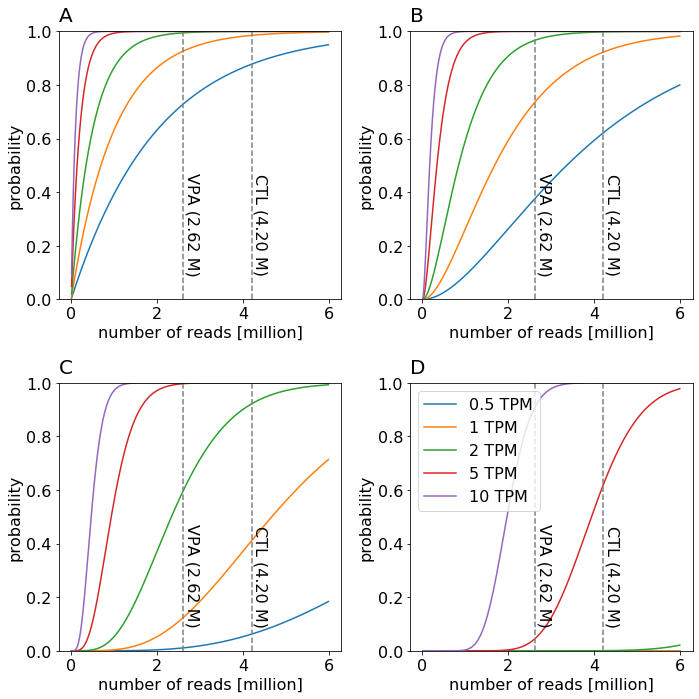

In [6]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 16})

f,axs=plt.subplots(2,2)
for nr,(ax,cov_th) in enumerate(zip(axs.flatten(),[1,2,5,20])):
    plot_saturation(isoseq, ax=ax,cov_th=cov_th, title='',x_range=(1e4,6e6,1e4), legend=False, xlabel='number of reads [million]', ylabel='probability')
    ax.set_title('ABCD'[nr],{'fontsize':20}, loc='left', pad=10)
ax.legend(loc='upper left')
f.tight_layout()
f.savefig(out_fn+'_Fig2_saturation.png') 

# Artifacts and biases
This section computes the QC metrics and depicts them as in Figure 3 of the manuscript

In [7]:
#these are the default definitions for the filter tags (except HIGH_SUPPORT):

ref_transcript_filter={
            'UNSPLICED':'len(exons)==1',
            'MULTIEXON':'len(exons)>1',
            'HIGH_SUPPORT':'transcript_support_level=="1"',
            'INTERNAL_PRIMING':'len(exons)==1 and downstream_A_content>.5'}

isoseq.add_filter( ref_transcript_filter=ref_transcript_filter)


100%|██████████| 151670/151670 [00:59<00:00, 2563.64it/s]


In [8]:
#compute distributions of the QC metrics
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]
for _,par in tr_stats:
    del par['title']
tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))
if 'liver' not in project:
    tr_stats[0]=(tr_stats[0][0][tr_stats[0][0].columns[[2,0,1]]],tr_stats[0][1])     
    tr_stats[3]=(tr_stats[3][0][tr_stats[3][0].columns[[2,0,3,1]]],tr_stats[3][1])     
    tr_stats[4]=(tr_stats[4][0][tr_stats[4][0].columns[[2,0,3,1]]],tr_stats[4][1])

In [9]:
#compute histogram of filter stats
f_stats={th:isoseq.filter_stats( groups=isoseq.groups(), weight_by_coverage=True,min_coverage=th) for th in [1]}
for i,th in enumerate(f_stats):
    f_stats[th][0].index=f_stats[th][0].index.str.replace('_','\n')
    del f_stats[th][1]['title']
f=sum(np.array([g.coverage[:,trid] for g,trid,tr in isoseq.iter_transcripts(include=(['RTTS', 'INTERNAL_PRIMING', 'FRAGMENT']))]))
total=sum(np.array([g.coverage[:,trid] for g,trid,tr in isoseq.iter_transcripts()]))
print(f'{f/total*100} percent filtered ({f} reads)')

[10.51445485  9.17255823] percent filtered ([441699 239879] reads)


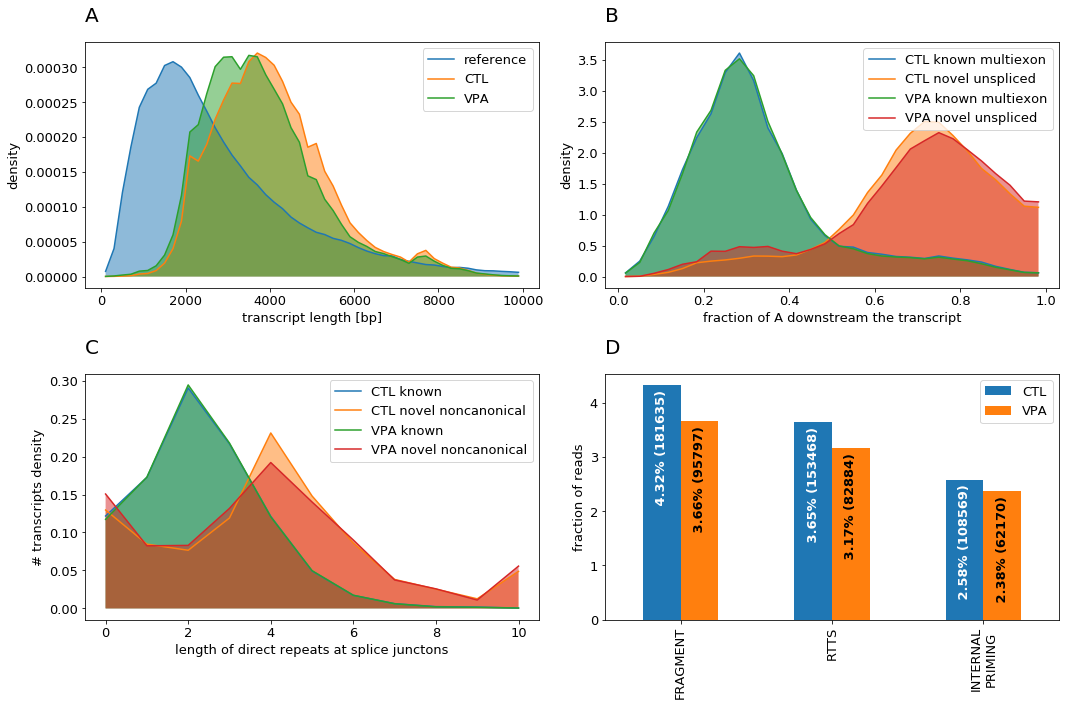

In [10]:
#Figure 3: QC plot
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(2,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],**tr_stats[0][1])  
#B) internal priming
plot_distr(tr_stats[4][0],smooth=3,ax=axs[0,1],density=True,fill=True, **tr_stats[4][1])  
#C) RTTS
plot_distr(tr_stats[3][0],ax=axs[1,0],density=True,**tr_stats[3][1])  
#D) frequency of artifacts
plot_bar(f_stats[1][0],ax=axs[1,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],**f_stats[1][1])  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)

plt.tight_layout()
plt.savefig(f"{out_fn}_Fig3_qc_metrics.png")

## Integration of CAGE data

In [11]:
#Import cage files
from intervaltree import IntervalTree, Interval
from glob import glob
import os
peaks={}
encode_metadata=pd.read_csv(f'{path}/ENCODE_HepG2_CAGE/metadata.tsv', sep='\t', index_col=0)

for file in glob(f'{path}/ENCODE_HepG2_CAGE/*.bed'):
    name=os.path.basename(file).replace('.bed','')
    cellline_name=encode_metadata.loc[name,'Biosample term name']
    assert encode_metadata.loc[name,'File assembly']=='GRCh38'
    print(f'{name}: {cellline_name}')

    with open(file) as fp: 
        while True: 
            line = fp.readline().rstrip().split('\t') 
            if not line[0]: 
                break
            peaks.setdefault(line[0]+line[5],[]).append(Interval(int(line[1]), int(line[2]), name))

peaks={chrom:IntervalTree(intervals) for chrom, intervals in peaks.items() }



ENCFF089AFK: HepG2
ENCFF220OWX: HepG2
ENCFF241CGD: HepG2
ENCFF248QKX: HepG2
ENCFF373BNI: HepG2
ENCFF419FNU: HepG2
ENCFF875ILB: HepG2
ENCFF885VJU: HepG2


In [12]:
# add cage data to isoseq transcripts
from tqdm import tqdm #2 minutes
pad=100 #consider the TSS +- 100 bases
for g,trid, tr in tqdm(isoseq.iter_transcripts(), total=isoseq.n_transcripts):
    tss=tr['exons'][0][0] if g.strand=='+' else tr['exons'][-1][1]
    tr['CAGE']=[i.data for i in peaks[g.chrom+g.strand].overlap(tss-pad,tss+pad)] if g.chrom+g.strand in peaks else []

100%|██████████| 829444/829444 [03:56<00:00, 3509.60it/s]


In [13]:
#18 seconds
for g,trid, tr in tqdm(isoseq.iter_ref_transcripts()):
    tss=tr['exons'][0][0] if g.strand=='+' else tr['exons'][-1][1]
    tr['CAGE']=[i.data for i in peaks[g.chrom+g.strand].overlap(tss-pad,tss+pad)] if g.chrom+g.strand in peaks else []

253250it [00:46, 5482.06it/s]


In [14]:
#check CAGE support of gencode transcripts
cage_ol_fragment=[]
for g,trid, tr in isoseq.iter_transcripts(include=['FRAGMENT']):
    #if sum(v for v in tr['coverage'].values())<2:
    #    continue
    if all(f[1] for f in tr['fragments']): #start exons missing: tr[fragments][1]>0
        cage_ol_fragment.append(len(tr['CAGE']))
print(f'{sum(c>0 for c in cage_ol_fragment)/len(cage_ol_fragment)*100}% of fragment tss have cage support')
cage_ol_gencode=[]
for g,trid, tr in isoseq.iter_transcripts(remove=['NOVEL_TRANSCRIPT']):
    if sum(v for v in tr['coverage'].values())<2:
        continue
    ref_tr=g.ref_transcripts[tr['annotation'][1]['FSM'][0]]    
    if 'transcript_support_level' in ref_tr and ref_tr['transcript_support_level']=='1':    
        cage_ol_gencode.append(len(tr['CAGE']))
        #cage_ol_gencode.append(len(ref_tr['CAGE']))
print(f'{sum(c>0 for c in cage_ol_gencode)/len(cage_ol_gencode)*100}% of level 1 gencode FSM tss have cage support')


9.854125052962896% of fragment tss have cage support
76.87439457539554% of level 1 gencode FSM tss have cage support


In [15]:
cage_ol_fragment={}
tss_cat=["5' fragment", "novel exonic TSS", "novel intronic TSS"]
bias=["RTTS", "FRAGMENT", "INTERNAL_PRIMING"]
for g,trid, tr in isoseq.iter_transcripts(include=tss_cat,min_coverage=2):#, remove=bias):
    for cat in tss_cat:
        if cat in tr['annotation'][1]:
            cage_ol_fragment.setdefault(cat, []).append(len(tr['CAGE']))
for g,trid, tr in isoseq.iter_transcripts(remove=['NOVEL_TRANSCRIPT'], min_coverage=2):
    ref_tr=g.ref_transcripts[tr['annotation'][1]['FSM'][0]]    
    if 'transcript_support_level' in ref_tr and ref_tr['transcript_support_level']=='1':    
        cage_ol_fragment.setdefault('level 1 gencode FSM TSS', []).append(len(tr['CAGE']))
for cat,ol in cage_ol_fragment.items():
    print(f'{sum(c>0 for c in ol)/len(ol):.3%} of {cat} have cage support')


31.121% of novel intronic TSS have cage support
10.125% of novel exonic TSS have cage support
11.695% of 5' fragment have cage support
76.874% of level 1 gencode FSM TSS have cage support


In [16]:
#adjust the requested number of cage 
for cat,ol in cage_ol_fragment.items():
    print(f'{sum(c>0 for c in ol)/len(ol):.1%} of {cat} have cage support')


31.1% of novel intronic TSS have cage support
10.1% of novel exonic TSS have cage support
11.7% of 5' fragment have cage support
76.9% of level 1 gencode FSM TSS have cage support


## Chimeric transcripts
In this section we analyze the chimeric alignments.

In [17]:
fusiontab=isoseq.chimeric_table().sort_values('total_cov', ascending=False)
fusion_cov=[ct[0] for ctl in isoseq.chimeric.values() for ct in ctl ]
cov_lic=[0,0]
for g,trid,tr in isoseq.iter_transcripts():
    if 'long_intron_chimeric' in tr:
        if 'VPA' in tr['coverage']:
            cov_lic[1]+=tr['coverage']['VPA']
        if 'CTL' in tr['coverage']:
            cov_lic[0]+=tr['coverage']['CTL']
print(f'total chimeric reads CTL: {cov_lic[0]+sum(c["CTL"] for c in fusion_cov if "CTL" in c)}')
print(f'total chimeric reads VPA: {cov_lic[1]+sum(c["VPA"] for c in fusion_cov if "VPA" in c)}')

malat1=fusiontab.loc[(fusiontab.gene1=='MALAT1') |(fusiontab.gene2=='MALAT1')]
other=fusiontab.loc[(fusiontab.gene1!='MALAT1') &(fusiontab.gene2!='MALAT1')]

print(f'malat1 CTL: {malat1.CTL_cov.sum()}')
print(f'malat1 VPA: {malat1.VPA_cov.sum()}')

print(f'{len(fusion_cov)} transcripts arise from chimeric reads, total coverage={sum(sum(c.values()) for c in fusion_cov)} ({sum(c["CTL"] for c in fusion_cov if "CTL" in c)} CTL +{sum(c["VPA"] for c in fusion_cov if "VPA" in c)} VPA )')
print(f'accroding to table: total coverage={sum(fusiontab.total_cov)} ({sum(fusiontab.CTL_cov)} CTL + {sum(fusiontab.VPA_cov)} VPA <<- this counts breakpoints not transcripts, hence ~30 more)')
# claim most are low coverage
sel=other.total_cov>=10
genes=set(other.gene1[sel]).union(set(other.gene2[sel]))
print(f'{(other.loc[sel].shape[0])} fusion candidates>10 reads, including {len(genes)} genes')
fusiontab.to_csv(f'{out_fn}_tab1_chimeric_reads.csv', index=False)
malat1.to_csv(f'{out_fn}_tab1_malat1_chimeric_reads.csv', index=False)
malat1.head()

total chimeric reads CTL: 8489
total chimeric reads VPA: 5441
malat1 CTL: 2144
malat1 VPA: 1287
1327 transcripts arise from chimeric reads, total coverage=5523 (3737 CTL +1786 VPA )
accroding to table: total coverage=5585 (3791 CTL + 1794 VPA <<- this counts breakpoints not transcripts, hence ~30 more)
21 fusion candidates>10 reads, including 30 genes


,name,chr1,strand1,breakpoint1,gene1,chr2,strand2,breakpoint2,gene2,total_cov,CTL_cov,VPA_cov
436,MALAT1_MALAT1,chr11,+,65500661,MALAT1,chr11,+,65499092,MALAT1,593,332,261
435,MALAT1_MALAT1,chr11,+,65502332,MALAT1,chr11,+,65499375,MALAT1,507,299,208
456,MALAT1_MALAT1,chr11,+,65500698,MALAT1,chr11,+,65499091,MALAT1,202,106,96
438,PB_novel_36558_MALAT1,chr11,+,65503695,PB_novel_36558,chr11,+,65499071,MALAT1,173,113,60
443,PB_novel_36558_MALAT1,chr11,+,65503804,PB_novel_36558,chr11,+,65499089,MALAT1,135,89,46


In [18]:
other[sel]

,name,chr1,strand1,breakpoint1,gene1,chr2,strand2,breakpoint2,gene2,total_cov,CTL_cov,VPA_cov
128,PB_novel_56121_MAGI1,KQ031385.1,-,14797,PB_novel_56121,chr3,-,65622090,MAGI1,272,151,121
452,PB_novel_36558_PB_novel_36558,chr11,+,65502946,PB_novel_36558,chr11,+,65499049,PB_novel_36558,47,35,12
612,GPC6_GPC6,chr13,+,93227617,GPC6,chr13,+,94286346,GPC6,31,26,5
647,KANSL1_ARL17B,chr17,-,46094561,KANSL1,KI270908.1,-,1090574,ARL17B,30,23,7
680,KANSL1_ARL17B,KI270908.1,-,796667,KANSL1,KI270908.1,-,1090574,ARL17B,29,23,6
645,PB_novel_48169_intergenic,chr17,-,43358962,PB_novel_48169,chr17,-,43365005,intergenic,27,5,22
415,NUTM2A-AS1_MINPP1,chr10,-,87326632,NUTM2A-AS1,chr10,+,87449472,MINPP1,24,13,11
221,intergenic_AC270107.3,chr5,+,70401668,intergenic,KV575243.1,+,60936,AC270107.3,22,16,6
7,CROCC_intergenic,chr1,+,16954362,CROCC,chr1,-,148013326,intergenic,20,12,8
636,BOLA2B_SMG1P5,chr16,-,30193361,BOLA2B,chr16,-,30288789,SMG1P5,19,16,3


In [19]:
# depict the MALAT1 locus (not shown in manuscript)
from pysam import AlignmentFile, FastaFile
# function to retrieve the genomic a content
def get_a_content(chrom, start, end, genome_file=genome_fn, wd=10):
    with FastaFile(genome_file) as genome_fh:
        seq=genome_fh.fetch(chrom, start-wd+1,end+wd)
    count={coi:[sum(c==coi for c in seq[:(2*wd)])] for coi in 'AT'}
    for i in range(2*wd,len(seq)):
        for coi in 'AT':
            last=count[coi][-1]
            count[coi].append(last+(seq[i]==coi)-(seq[i-2*wd]==coi))
    return [ca/(2*wd) if ca>count['T'][i] else count['T'][i]/(2*wd) for i,ca in enumerate(count['A'])] 

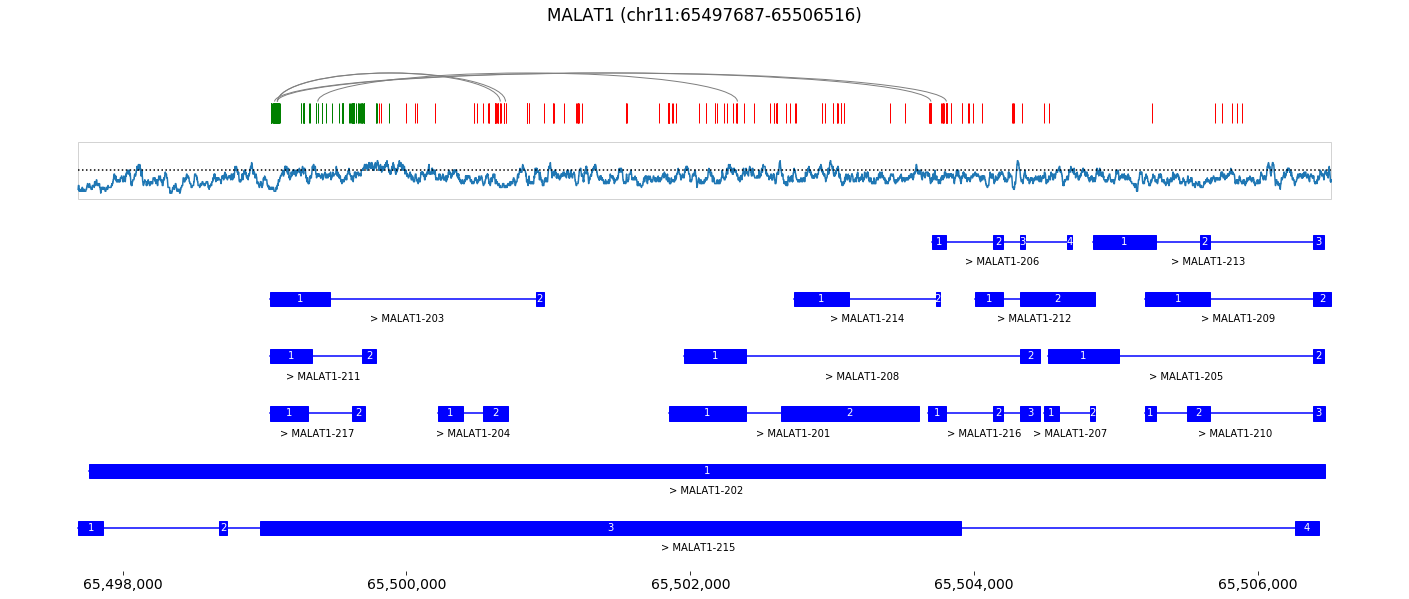

In [20]:
from matplotlib import patches

plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams.update({'font.size': 14})



fig, ax = plt.subplots(1)
ax.plot(malat1.breakpoint1, [7.5]*len(malat1),'r|',markersize= 20 )
ax.plot(malat1.breakpoint2, [7.5]*len(malat1),'g|',markersize= 20)
isoseq['MALAT1'].gene_track(ax=ax)
for _,row in malat1.head().iterrows():
    bp1,bp2=row.breakpoint1, row.breakpoint2
    bow=patches.Arc(((bp1+bp2)/2, 7.7), width=bp1-bp2, height=1,theta1=0, theta2=180,linewidth=1,edgecolor='grey',zorder=1)
    ax.add_patch(bow)

g_start=min(tr['exons'][0][0] for tr in isoseq['MALAT1'].ref_transcripts)
g_end=max(tr['exons'][-1][1] for tr in isoseq['MALAT1'].ref_transcripts)
a_cont=get_a_content('chr11',g_start, g_end, wd=15)
ax.plot(range(g_start, g_end),[val+6 for val in a_cont])
ax.plot((g_start, g_end),(6.5,6.5), 'k:')
box=patches.Rectangle((g_start, 6), width=g_end-g_start, height=1,linewidth=1,edgecolor='lightgrey',zorder=1, fill=False)
ax.add_patch(box)

ax.set_ylim(-.5,9)
ax.set_xlim(g_start-500,g_end+500)
#ax.axis('off')
ax.set(frame_on=False)   
ax.get_yaxis().set_visible(False)
plt.savefig(f"{out_fn}_Fig_malat1.png")

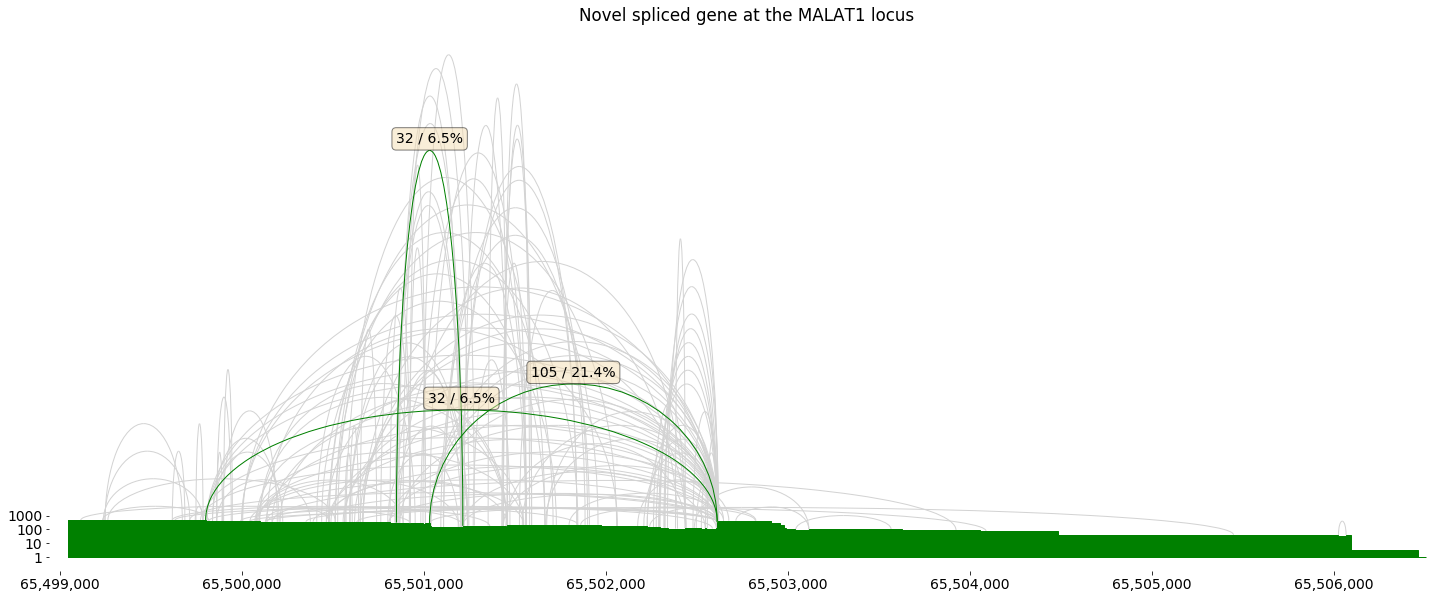

In [21]:
# some reads of that locus get assigned to a novel gene, since they are spliced and do not share any junction with the annotation:
plt.rcParams["figure.figsize"] = (25,10)
g=isoseq["MALAT1"]
malat1_locus=(g.chrom, g.start, g.end)
for alt_g in sorted(list(isoseq.iter_genes(region=malat1_locus)), key=lambda x: - x.coverage.sum()):
    if alt_g.name != 'MALAT1':
        f,axs=alt_g.sashimi_figure(draw_gene_track=False)
        axs[0].set_title("Novel spliced gene at the MALAT1 locus")
        break

(<Figure size 1800x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67b8658bd0>,
       dtype=object))

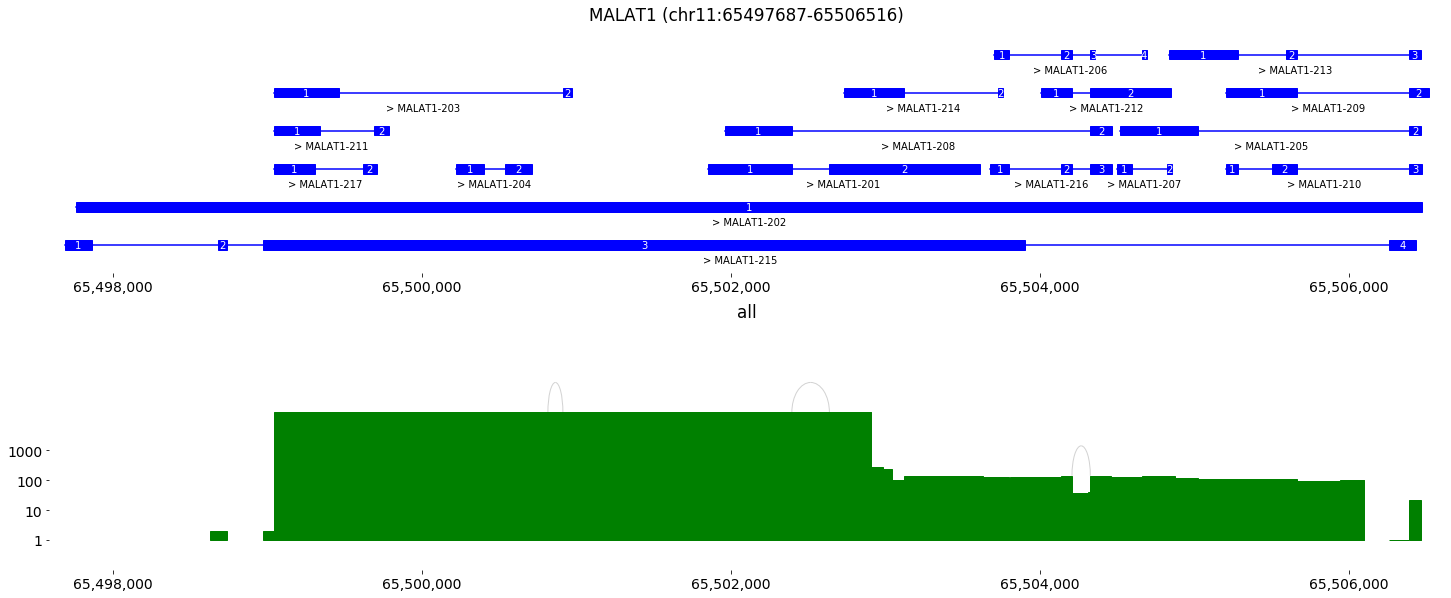

In [22]:
isoseq['MALAT1'].sashimi_figure()

## Novel isoform classification
In this section, we replicate the classification of novel transcripts, including Figure 4 of the manuscript

FSM: {'FSM': [0]}
5' fragment: {"5' fragment": [[12, 33]]}
3' fragment: {"3' fragment": [[55, 80]]}
mono exon: {'mono-exon': []}
exon skipping: {'exon skipping': [[30, 40]]}
intron retention: {'intron retention': [(20, 30)]}
novel combination: {'novel combination': []}
novel junction: {'novel combination': []}
novel exonic TSS: {'novel exonic TSS': [(26, 30)]}
novel exonic PAS: {'novel exonic PAS': [(60, 66)]}
novel 5' splice site: {"novel 5' splice site": [(24, -4)]}
novel 3' splice site: {"novel 3' splice site": [(26, 4)]}
novel exon: {'novel exon': [[43, 47]]}
novel intronic TSS: {'novel intronic TSS': [[43, 47]]}
novel intronic PAS: {'novel intronic PAS': [[82, 90]]}


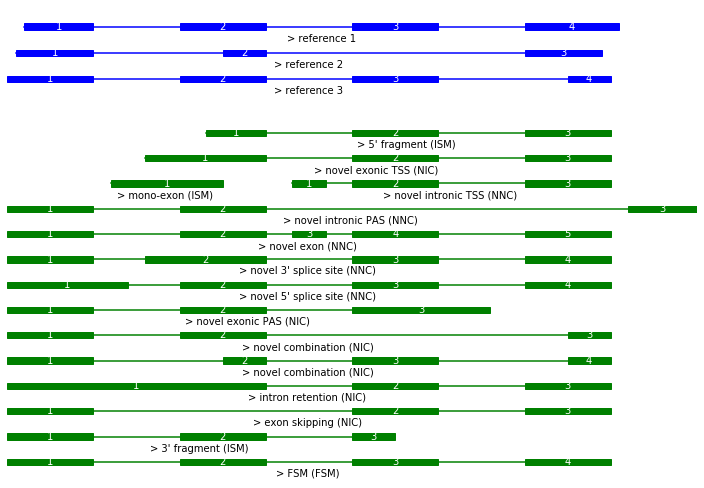

In [23]:

import isotools 
ref=[[[12,20],[30,40], [50,60],[70,81]],
     [[11,20],[35,40],         [70,79]],
     [[10,20],[30,40], [50,60],[75,80]]]
novel={'FSM':         [[10,20],[30,40], [50,60],[70,80]],
       "5' fragment": [[33,40], [50,60],[70,80]],
       "3' fragment": [[10,20],[30,40], [50,55]],
       "mono exon"  : [[22,35]],
       "exon skipping"     :  [[10,20], [50,60],[70,80]],
       "intron retention"  :  [[10,40], [50,60],[70,80]],
       "novel combination" :  [[10,20],[35,40], [50,60],[75,80]],
       "novel junction"  :   [[10,20],[30,40], [75,80]],
       "novel exonic TSS"  :  [[26,40], [50,60],[70,80]],
       "novel exonic PAS"  :  [[10,20],[30,40], [50,66]],
       "novel 5' splice site":[[10,24],[30,40], [50,60],[70,80]],
       "novel 3' splice site":[[10,20],[26,40], [50,60],[70,80]],
       "novel exon"  :        [[10,20],[30,40],[43,47], [50,60],[70,80]],
       "novel intronic TSS" : [[43,47],[50,60],[70,80]],
       "novel intronic PAS" : [[10,20],[30,40], [82,90]]}
ref={'transcripts':[{'exons':e, 'transcript_name':f'reference {i+1}'} for i,e in enumerate(ref)]}
transcripts=[{'exons':e, 'transcript_name':n} for n,e in novel.items()]
example=isotools.Gene(10,80,{'strand':'+','ID':'example','reference':ref, 'transcripts':transcripts},None)
f,axs=plt.subplots(2,figsize=(10,7), gridspec_kw={'height_ratios': [1, 4]})
cat=['FSM','ISM','NIC','NNC','novel gene']
sg=example.ref_segment_graph
for novel in example.transcripts:
    alt_splice=sg.get_alternative_splicing(novel['exons'])
    print(f"{novel['transcript_name']}: {alt_splice[1]}")
    novel['transcript_name']=f"{','.join(alt_splice[1])} ({cat[alt_splice[0]]}) "
    
example.gene_track(ax=axs[0], x_range=[10,90], title='')
example.gene_track(reference=False,ax=axs[1], x_range=[10,90], title='', color='green')  
for ax in axs:
    ax.get_xaxis().set_visible(False)
f.tight_layout()
plt.savefig(f"{out_fn}_Fig4a_altsplice_example.png")

In [24]:
# explain refined sqanti 
# barplot (zu figure 3?)
cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

In [25]:
altsplice[0][0].loc["FSM"]/altsplice[0][0].loc["total"]

CTL    0.725892
VPA    0.734485
dtype: float64

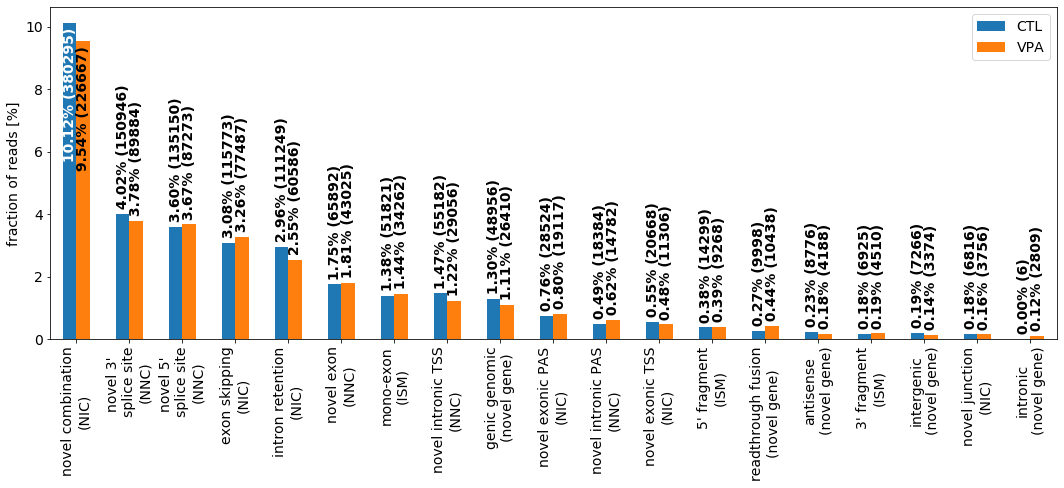

In [26]:
plt.rcParams["figure.figsize"] = (15,7)
fig, ax = plt.subplots( 1)

plot_bar(altsplice[0][0],ax=ax,ylabel='fraction of reads [%]', drop_categories=['FSM'])  
#plot_bar(altsplice[1][0],ax=axs[1],**altsplice[1][1])  
fig.tight_layout()
plt.savefig(f"{out_fn}_Fig4_altsplice.png")

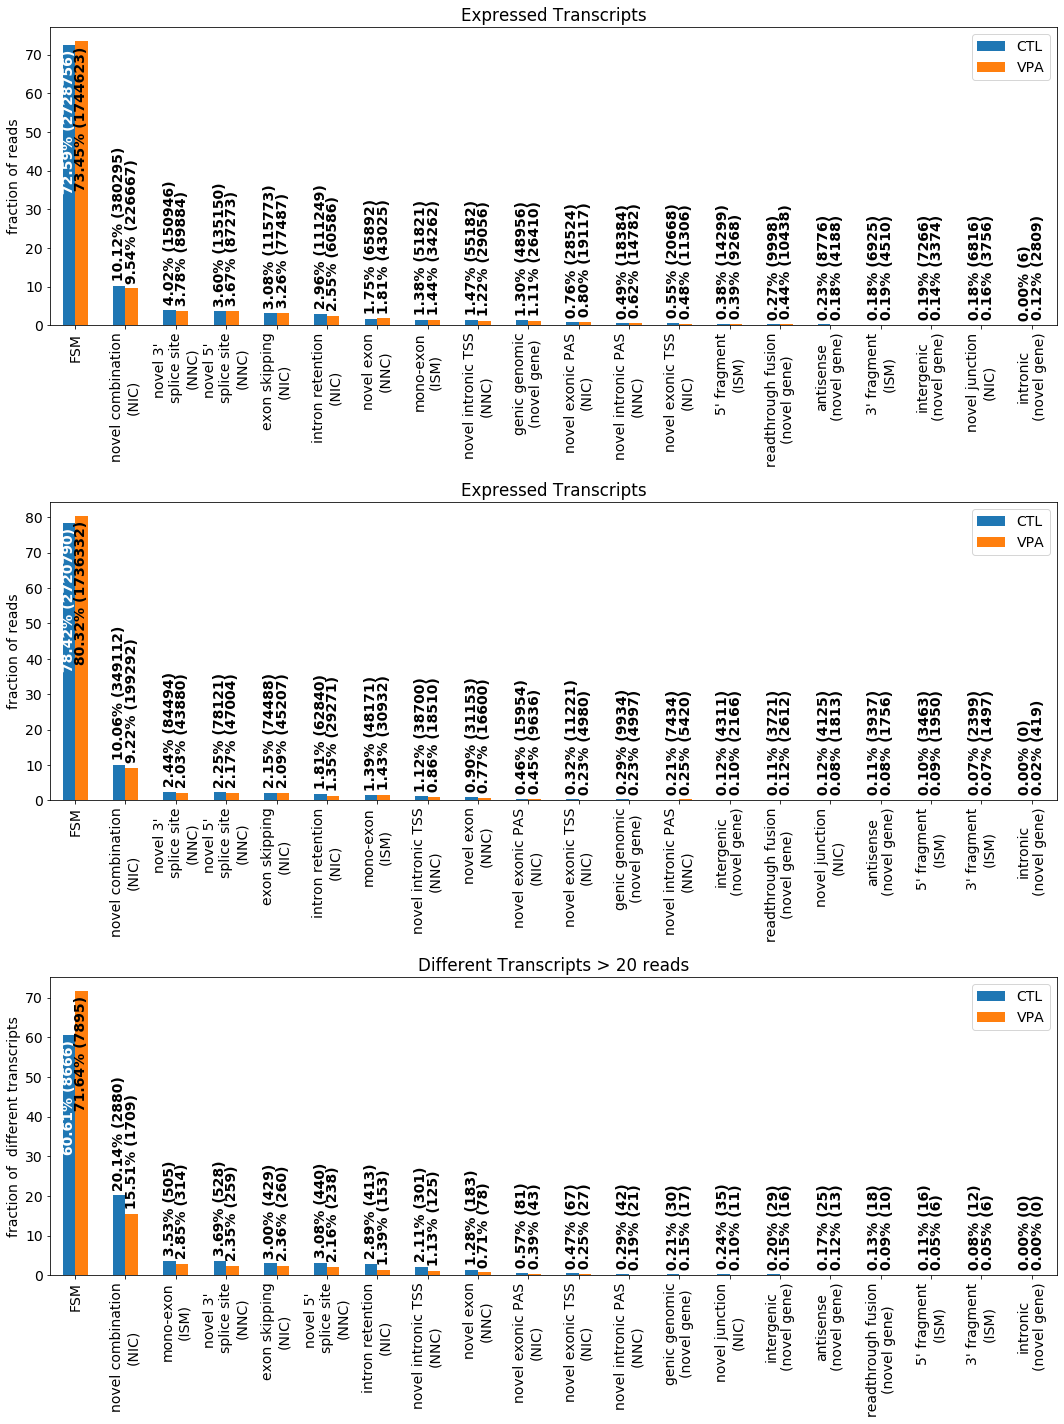

In [27]:
#alternative plots for fig4
plt.rcParams["figure.figsize"] = (15,20)
fig, ax = plt.subplots( 3)

for i in range(3):
    plot_bar(altsplice[i][0],ax=ax[i],**altsplice[i][1])  
plt.tight_layout()


## Quantification
This section compares RNA-seq transcript quantification by rsem with isoseq read counts per transcript.

In [28]:
illu_gene_tpm=pd.read_csv(f'{out_fn}_tab2_illumina_isoseq_gene_expression.csv').set_index( "gene_id")
illu_transcript_tpm=pd.read_csv(f'{out_fn}_tab3_illumina_isoseq_transcript_expression.csv').set_index(["tr_id", "gene_id"])
illu_transcript_tpm.head()

,,gene_name,chr,start,end,strand,gene_type,gene_level,gene_tag,transcript_type,transcript_support_level,CDS,rsem_genelength,isoseq_genelength,illumina_CTL_tpm,illumina_VPA_tpm,isoseq_CTL_tpm,isoseq_VPA_tpm
tr_id,gene_id,,,,,,,,,,,,,,,,,
ENST00000618686.1,ENSG00000278704.1,BX004987.1,GL000009.2,56139,58376,-,protein_coding,3,none,protein_coding,NaN,"(58080, 58308)",2237.0,0.0,0.0300,0.1100,0.000000,0.000000
ENST00000613230.1,ENSG00000277400.1,AC145212.1,GL000194.1,53589,115018,-,protein_coding,3,none,protein_coding,1,"(53646, 54021)",2179.0,2203.0,2.4825,5.9450,0.230754,3.736880
ENST00000400754.4,ENSG00000274847.1,MAFIP,GL000194.1,53593,115055,-,protein_coding,3,none,protein_coding,1,"(54730, 112848)",1599.0,1593.0,5.9550,10.5675,0.000000,0.373688
ENST00000618679.1,ENSG00000277428.1,Y_RNA,GL000195.1,37433,37534,-,misc_RNA,3,none,misc_RNA,NaN,NaN,101.0,0.0,0.0000,0.0000,0.000000,0.000000
ENST00000612465.1,ENSG00000276256.1,AC011043.1,GL000195.1,42938,49164,-,protein_coding,3,none,protein_coding,2,"(44723, 49117)",2195.0,0.0,3.4250,2.3475,0.000000,0.000000


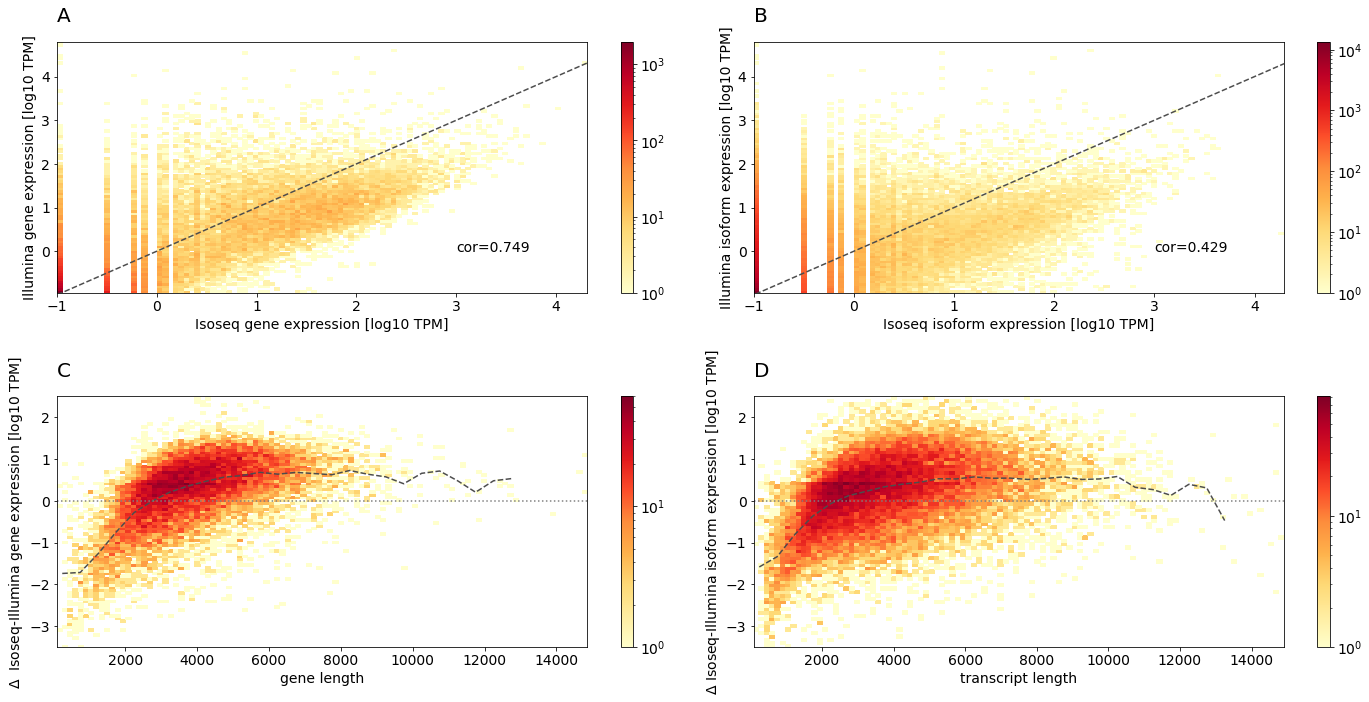

In [29]:

plt.rcParams["figure.figsize"] = (20,10)

from matplotlib.colors import LogNorm
from isotools._utils import pairwise

f=(illu_gene_tpm.illumina_CTL_tpm>0.01 ) #&(illu_gene_tpm.isoseq_CTL_tpm>0 )#&(illu_gene_tpm.rsem_genelength>4000 )
fig, axs = plt.subplots( 2,2)

x=np.log10(illu_gene_tpm.isoseq_CTL_tpm[f]+.1)
y=np.log10(illu_gene_tpm.illumina_CTL_tpm[f]+.1)
hist=axs[0,0].hist2d(x,y,100,norm=LogNorm(),cmap='YlOrRd')
fig.colorbar(hist[3], ax=axs[0,0])
axs[0,0].plot([-2, 5], [-2, 5], ls="--", c=".3")
axs[0,0].set_xlabel('Isoseq gene expression [log10 TPM]')
axs[0,0].set_ylabel('Illumina gene expression [log10 TPM]')
axs[0,0].text(3,0,f'cor={np.corrcoef(x,y)[1,0]:.3f}')


f=(illu_transcript_tpm.illumina_CTL_tpm>0.01 ) #&(illu_transcript_tpm.isoseq_CTL_tpm>0 )
x=np.log10(illu_transcript_tpm.isoseq_CTL_tpm[f]+.1)
y=np.log10(illu_transcript_tpm.illumina_CTL_tpm[f]+.1)
hist=axs[0,1].hist2d(x,y,100,norm=LogNorm(),cmap='YlOrRd')
fig.colorbar(hist[3], ax=axs[0,1])
axs[0,1].plot([-2, 5], [-2, 5], ls="--", c=".3")
axs[0,1].set_xlabel('Isoseq isoform expression [log10 TPM]')
axs[0,1].set_ylabel('Illumina isoform expression [log10 TPM]')
axs[0,1].text(3,0,f'cor={np.corrcoef(x,y)[1,0]:.3f}')


bins=range(0,14000,500)
f=(illu_gene_tpm.illumina_CTL_tpm>0.01) & (illu_gene_tpm.isoseq_CTL_tpm>0 )& (illu_gene_tpm.isoseq_genelength<15000) 
y=np.log10(illu_gene_tpm.isoseq_CTL_tpm[f]+.1)-np.log10(illu_gene_tpm.illumina_CTL_tpm[f]+.1)
#x=[gl for gl,sel in zip(glen,f) if sel]
#x=[gl for gl,sel in zip(illu_glen,f) if sel]
x=illu_gene_tpm.isoseq_genelength[f]
mean_y=[sum(ybin)/len(ybin) if ybin else np.nan for ybin in [[yi for xi,yi in zip(x,y) if lb<xi<=ub ] for lb,ub in pairwise(bins)]] 
hist=axs[1,0].hist2d(x,y, 100,norm=LogNorm(),cmap='YlOrRd')
fig.colorbar(hist[3], ax=axs[1,0])
axs[1,0].plot([(a+b)/2 for a,b in pairwise(bins)],mean_y , ls="--", c=".3")
axs[1,0].axhline( ls=":", c=".5")
axs[1,0].set_xlabel('gene length')
axs[1,0].set_ylabel(r'$\Delta$  Isoseq-Illumina gene expression [log10 TPM]')
axs[1,0].set_ylim(-3.5,2.5)

#axs[1,0].text(4000,-2,f'this is based on mean reference (gencode) transcript length\nweighted by isoseq expression')

f=(illu_transcript_tpm.illumina_CTL_tpm>0.01) & (illu_transcript_tpm.isoseq_CTL_tpm>0 ) & (illu_transcript_tpm.isoseq_genelength<15000)
y=np.log10(illu_transcript_tpm.isoseq_CTL_tpm[f]+.1)-np.log10(illu_transcript_tpm.illumina_CTL_tpm[f]+.1)
x=illu_transcript_tpm.isoseq_genelength[f]
mean_y=[sum(ybin)/len(ybin) if ybin else np.nan for ybin in [[yi for xi,yi in zip(x,y) if lb<xi<=ub ] for lb,ub in pairwise(bins)]] 
hist=axs[1,1].hist2d(x,y, 100,norm=LogNorm(),cmap='YlOrRd')
fig.colorbar(hist[3], ax=axs[1,1])
axs[1,1].plot([(a+b)/2 for a,b in pairwise(bins)],mean_y , ls="--", c=".3")
axs[1,1].axhline( ls=":", c=".5")
axs[1,1].set_xlabel('transcript length')
axs[1,1].set_ylabel(r'$\Delta$ Isoseq-Illumina isoform expression [log10 TPM]')
axs[1,1].set_ylim(-3.5,2.5)

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
    
fig.tight_layout()
plt.savefig(f"{out_fn}_Fig5_Isoseq_vs_Illumina_expression.png")

## Differential splicing
In this section we apply the statistical tests, to identify differential splicing events between CTL and VPA treated hepatocytes. 

In [30]:
#min_cov both paths must have that many reads (combined)
#min_n: each sample must have that many reads over both paths
res=isoseq.altsplice_test(groups=['CTL', 'VPA'],min_n=10).sort_values('pvalue')
res.to_csv(f'{out_fn}_tab4_differential_splicing.csv', index=True)
#res=pd.read_csv(f'{out_fn}_tab4_differential_splicing.csv')
res.head()


INFO:testing differential splicing for CTL (1) vs VPA (1) using proportions test
100%|██████████| 151670/151670 [14:32<00:00, 173.78it/s] 


,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,CTL_PSI,CTL_disp,VPA_PSI,VPA_disp,total_PSI,total_disp,CTL_CTL_in_cov,CTL_CTL_total_cov,VPA_VPA_in_cov,VPA_VPA_total_cov
18570,SLC39A14,ENSG00000104635.15,chr8,+,22408496,22414779,ME,False,0.000000e+00,0.000000e+00,0.506763,0,0.210480,0,0.404409,0,7568,14934,1659,7882
1634,GNG12,ENSG00000172380.6,chr1,-,67717963,67718084,TSS,True,4.654688e-267,4.627616e-271,0.049881,0,0.290463,0,0.144611,0,335,6716,1267,4362
3658,PSAP,ENSG00000197746.14,chr10,-,71822007,71825836,5AS,True,5.911088e-259,8.815064e-263,0.089206,0,0.265184,0,0.188241,0,938,10515,3589,13534
10513,PPP1CB,ENSG00000213639.10,chr2,+,28751678,28751820,TSS,False,2.159496e-186,4.293873e-190,0.099855,0,0.525737,0,0.309033,0,207,2073,1052,2001
10514,PPP1CB,ENSG00000213639.10,chr2,+,28751803,28752176,TSS,True,4.173779e-174,1.037376e-177,0.858659,0,0.433783,0,0.649975,0,1780,2073,868,2001


In [31]:
sig=(res.padj<.01) & (res.splice_type.isin( ["ME", "ES","5AS","3AS","IR"]))
#res.loc[sig].head(20)
res.loc[res.gene=='MCL1']


,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,CTL_PSI,CTL_disp,VPA_PSI,VPA_disp,total_PSI,total_disp,CTL_CTL_in_cov,CTL_CTL_total_cov,VPA_VPA_in_cov,VPA_VPA_total_cov
662,MCL1,ENSG00000143384.14,chr1,-,150577491,150578842,5AS,False,0.033524,0.004895,0.712121,0,0.481013,0,0.586207,0,47,66,38,79


In [32]:
sig=(res.padj<.01) & (res.splice_type.isin( ["ME", "ES","5AS","3AS","IR"]))
groups=['CTL', 'VPA']
print(f'{sum(sig)} differential splice sites in {len(res.loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')


806 differential splice sites in 556 genes for CTL vs VPA


In [33]:
for st in ["ME", "ES","5AS","3AS","IR","TSS","PAS"]:
    sel=(res.padj<.01) &(res.splice_type==st)
    print(f'{sum(sel)} differential {st} sites ({sum(sel)/sum(sig):.1%}) in {len(res.loc[sel,"gene"].unique())} genes for {" vs ".join(groups)}')


26 differential ME sites (3.2%) in 20 genes for CTL vs VPA
259 differential ES sites (32.1%) in 239 genes for CTL vs VPA
105 differential 5AS sites (13.0%) in 98 genes for CTL vs VPA
62 differential 3AS sites (7.7%) in 61 genes for CTL vs VPA
354 differential IR sites (43.9%) in 233 genes for CTL vs VPA
974 differential TSS sites (120.8%) in 646 genes for CTL vs VPA
306 differential PAS sites (38.0%) in 239 genes for CTL vs VPA


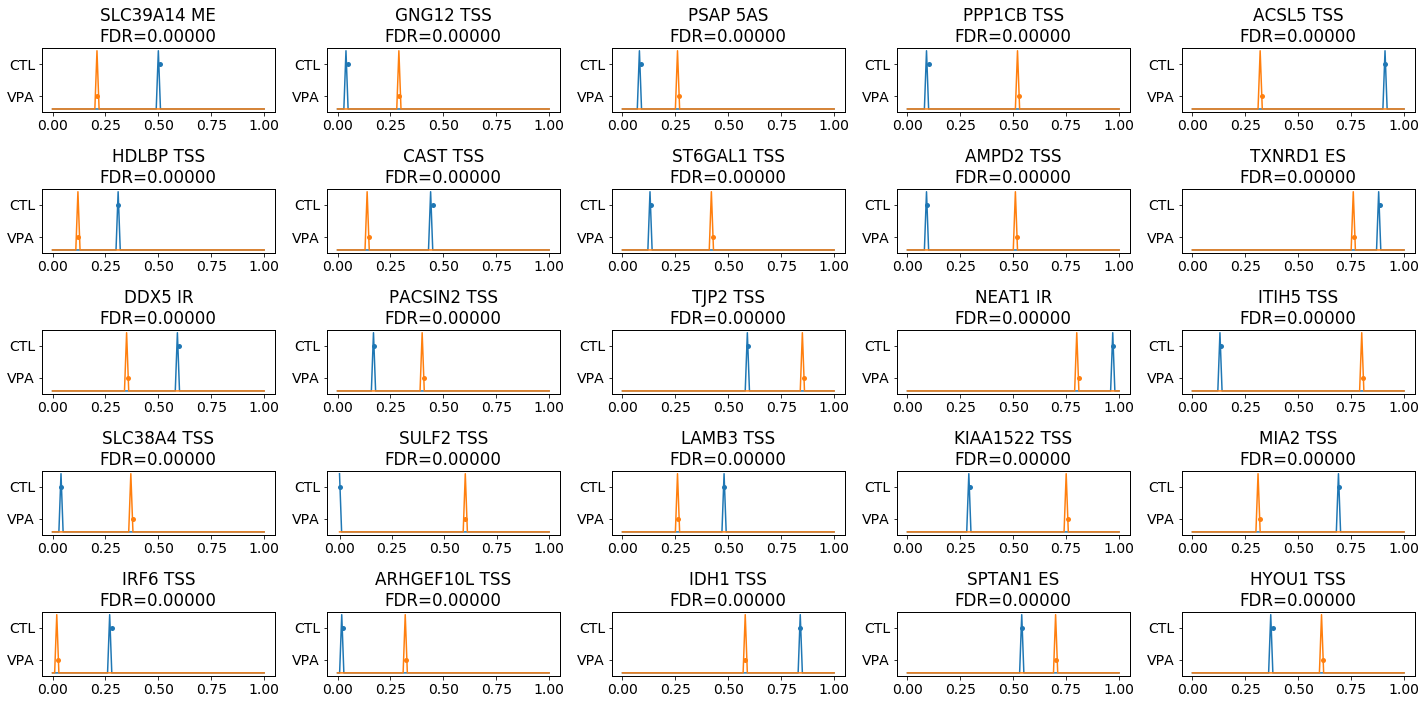

In [34]:
plotted=isotools.plots.plot_diff_results(res,min_support=1)

In [35]:
#compare to alternative test
res_lr=isoseq.altsplice_test(groups=['CTL', 'VPA'],min_n=10, test='binom_lr').sort_values('pvalue')
res_lr.to_csv(f'{out_fn}_tab4_lr_differential_splicing.csv', index=True)
#res=pd.read_csv(f'{out_fn}_tab4_differential_splicing.csv')
res_lr.head()
res['lr_pvalue']=res_lr['pvalue']

INFO:testing differential splicing for CTL (1) vs VPA (1) using binom_lr test
100%|██████████| 151670/151670 [11:56<00:00, 211.77it/s] 


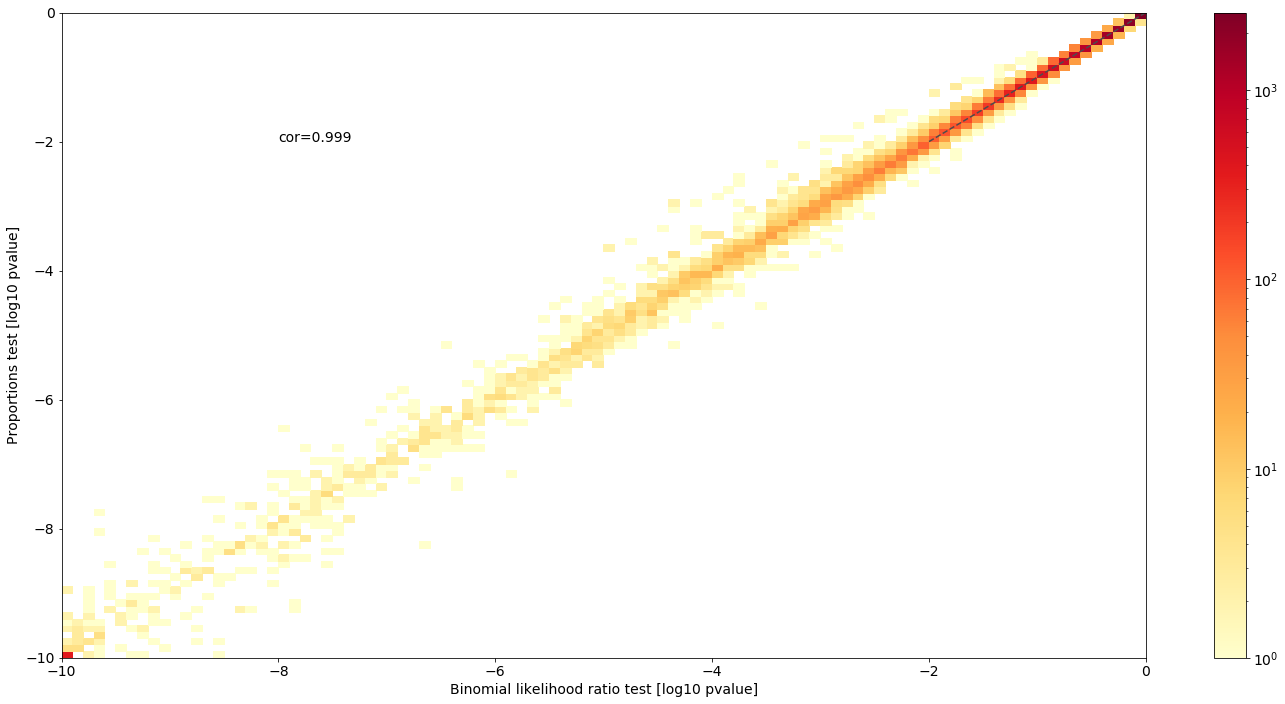

In [36]:
from matplotlib.colors import LogNorm

fig, ax=plt.subplots()
x=np.log10(res['lr_pvalue']+1e-10)
y=np.log10(res['pvalue']+1e-10)
#x=res['lr_pvalue']
#y=res['pvalue']
hist=ax.hist2d(x,y,100,norm=LogNorm(),cmap='YlOrRd')
fig.colorbar(hist[3], ax=ax)
ax.plot([-2, 5], [-2, 5], ls="--", c=".3")
ax.set_xlabel('Binomial likelihood ratio test [log10 pvalue]')
ax.set_ylabel('Proportions test [log10 pvalue]')
ax.text(-8,-2,f'cor={np.corrcoef(x,y)[1,0]:.3f}')
fig.tight_layout()
plt.savefig(f"{out_fn}_SupplFig_proportions_vs_lr_test.png")